# SPI script
Script to generate SPI for ACS GWLs

Chore list:
- update spi function in core functions
- add in monthly / daily functionality into function
- write spi_array as netcdf

In [4]:
import os
os.chdir('/g/data/mn51/users/jb6465/acs-drought/percentiles_spi_spei_smi')
import dictionaries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from core_functions import mask_ocean, calculate_spi, load_target_variable
# from plot_write_functions import plot_write_percentile_threshold, plot_comparison_box_whisker, plot_comparison_heatmap

### DASK setup

In [1]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41857,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:45155,Total threads: 1
Dashboard: /proxy/41835/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:32797,


In [18]:
# client.close()

### Load rainfall

In [5]:
BC_SWITCH = 'raw' #raw input output
BC_METHOD = 'QME'
BC_SOURCE = 'AGCD' #AGCD BARRA-R2

In [6]:
rain = load_target_variable('var_p', 3, ['full'],\
                            bc=BC_SWITCH, bc_method=BC_METHOD, bc_source=BC_SOURCE)

---> USING RAW DATA FROM py18 AND hq89

---> LOADING FULL PERIOD
- AGCD
- BARPA-R-CMCC-ESM2 (r1i1p1f1)
- BARPA-R-ACCESS-ESM1-5 (r6i1p1f1)
- BARPA-R-ACCESS-CM2 (r4i1p1f1)
- BARPA-R-EC-Earth3 (r1i1p1f1)
- BARPA-R-CESM2 (r11i1p1f1)
- BARPA-R-MPI-ESM1-2-HR (r1i1p1f1)
- BARPA-R-NorESM2-MM (r1i1p1f1)
- CCAM-v2203-SN-CMCC-ESM2 (r1i1p1f1)
- CCAM-v2203-SN-ACCESS-ESM1-5 (r6i1p1f1)
- CCAM-v2203-SN-ACCESS-CM2 (r4i1p1f1)
- CCAM-v2203-SN-EC-Earth3 (r1i1p1f1)
- CCAM-v2203-SN-CESM2 (r11i1p1f1)
- CCAM-v2203-SN-CNRM-ESM2-1 (r1i1p1f2)


In [7]:
%%time
import numpy as np
import xarray as xr
from scipy.stats import gamma, norm
import dask.array as da
import warnings 

# ignore "consider scattering" warnings
warnings.filterwarnings("ignore", category=UserWarning)

fitting_method = 'MLE'
input_array = (rain['full']['BARPA-R']['ACCESS-ESM1-5']).astype(np.float32)

def compute_spi(full_period, base_period_start_year, base_period_end_year):
    
    ### Gamma distribution requires non-zero values - assign random value to avoid NaN gamma fit errors
    base_period = full_period.sel(time=slice('%s-01-01' % (base_period_start_year),\
                                             '%s-12-31' % (base_period_end_year)))
    non_zero_base_period = base_period.where(base_period > 0, np.random.uniform(0.1, 1, size=base_period.shape))

    ### Determine fit parameters along the time axis
    alpha, loc, beta = xr.apply_ufunc(
        gamma.fit,
        non_zero_base_period,
        input_core_dims=[['time']],
        output_core_dims=[[], [], []],
        vectorize=True,
        dask='parallelized',
        dask_gufunc_kwargs={'allow_rechunk': True},
        output_dtypes=[float, float, float],
        kwargs={'floc': 0, 'method': fitting_method}
    )
    
    ### Apply gamma parameters from base period to gamma CDFs for full period accounting for zero observations
    p_zero = ((full_period == 0).sum(dim='time') / full_period.sizes['time']).values
    gamma_cdf = gamma.cdf(full_period, alpha, loc=loc, scale=beta)
    cdf = p_zero + (1 - p_zero) * gamma_cdf
    
    ### Apply inverse normal distribution
    norm_ppf = norm.ppf(cdf)

    return xr.DataArray(norm_ppf, coords=full_period.coords, dims=full_period.dims)

# Group by month and apply the SPI calculation
spi_array_grouped = input_array.groupby('time.month').map(lambda x: compute_spi(x, '1965', '2014'))


CPU times: user 27min 12s, sys: 3min 1s, total: 30min 13s
Wall time: 1h 31min 18s


In [9]:
spi_array = spi_array_grouped.assign_coords(time=input_array['time'])

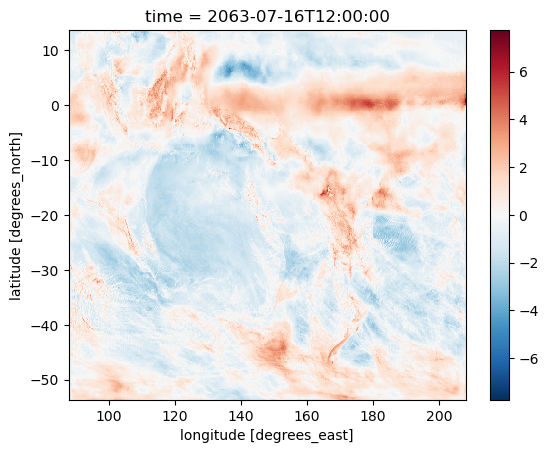

In [10]:
spi_array[1230].plot()

In [11]:
spi_array.rename('SPI3').to_netcdf('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/parametric_SPI3_ACCESS-ESM1-5_1961_2100__baseperiod19652014.nc')

In [49]:
david_spi = xr.open_dataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/SPI3_ACCESS-ESM1-5_1960-2100.nc')

In [2]:
jess_spi = xr.open_dataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/parametric_SPI3_ACCESS-ESM1-5_1961_2100.nc')
jess_spi_short_base_period = xr.open_dataset('/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/parametric_SPI3_ACCESS-ESM1-5_1961_2100__baseperiod19852014.nc')

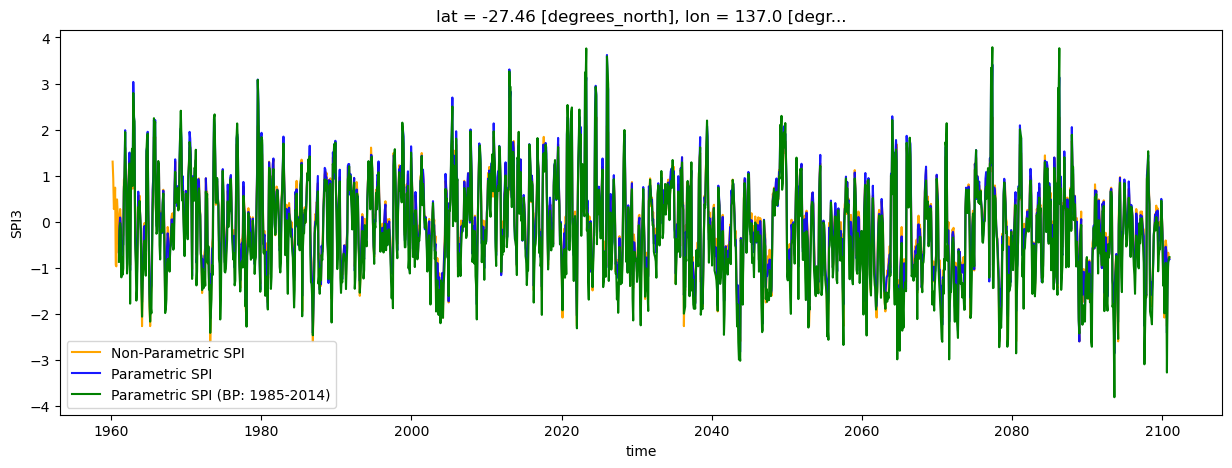

In [29]:
plt.figure(figsize=(15, 5))
david_spi.sel(lat=-27.5,lon=137,method='nearest').SPI3.plot(label='Non-Parametric SPI', color='orange')
jess_spi.sel(lat=-27.5,lon=137,method='nearest').SPI3.plot(label='Parametric SPI', color='b', alpha=0.9)
jess_spi_short_base_period.sel(lat=-27.5,lon=137,method='nearest').SPI3.plot(label='Parametric SPI (BP: 1985-2014)', color='green')

plt.legend()